# Video Game Review Sentiment Analysis Notebook

In [20]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  6 22:27:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0              29W /  70W |   1025MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 1. Datasets & Dependencies

### 1.1 Importing the necessary libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

Mounted at /content/drive


### 1.2 Reading the datasets

In [4]:
df_with_label = pd.read_csv('/content/drive/My Drive/Video game review sentiment analysis/dataset/steam game review dataset/train_gr/train.csv')
df_with_label.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


## 2. Preprocessing

### 2.1 Exploratory Data Analysis (EDA)

#### 2.1.1 Data Imbalance
Check whether the dataset has the problems about data imbalance and balance the dataset.

In [ ]:
# Check the labels count of dataset `df_with_label`
label_counts = df_with_label['user_suggestion'].value_counts()
print(label_counts)

user_suggestion
1    9968
0    7526
Name: count, dtype: int64


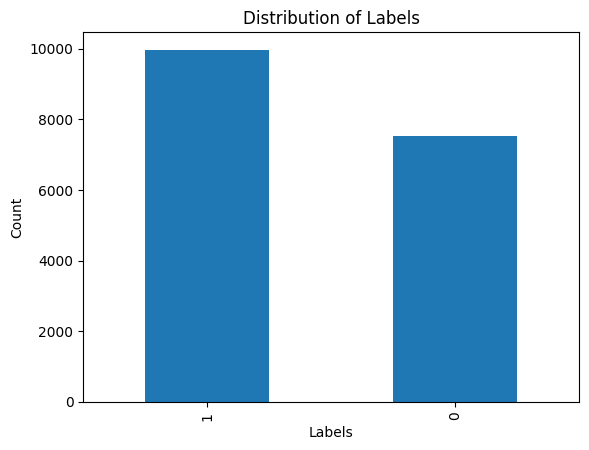

In [ ]:
# Plot the distribution of the labels
import matplotlib.pyplot as plt

label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

Since the count of labels are not significantly different, so the dataset is balanced data.

#### 2.1.2 WordCloud

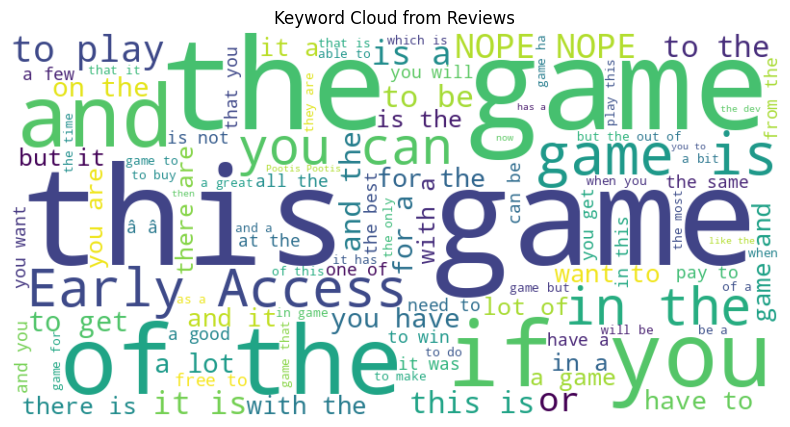

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Integrate all the reviews into a text
all_text = ' '.join(df_with_label['user_review'].astype(str))

# Build wordcloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', stopwords='english').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Cloud from Reviews")
plt.show()

Too much unnecessary and meaningless keywords displayed in the wordcloud, which should be solve in the extracting part later.

#### 2.1.3 Word Frequency

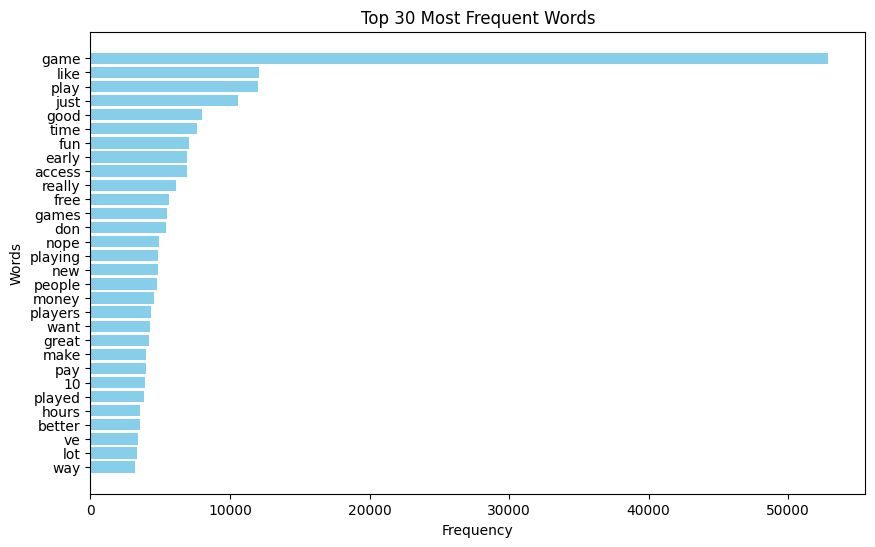

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Remove the stop words
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(df_with_label['user_review'].astype(str))
word_counts = X.toarray().sum(axis=0)

# Create frequency dataframe
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame({'Word': words, 'Frequency': word_counts}).sort_values(by='Frequency', ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(word_freq_df['Word'], word_freq_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()

High frequent words can't deliver useful insights of the game. Use phrases instead of single words might be a option to gain insights.

### 2.2 Preprocessing for BERT
Based on the pre-training of BERT model, it has learned how to handle the complex problems of texts. Thus, only case-sensitive problems, hyperlinks and HTML labels will be cleaned.

In [5]:
# Text preprocessing functions for BERT
import re

def cleaning_text_bert(text):
  # Replace all the uppercase characters to lowercase ones
  text = text.lower()

  # Remove all the hyperlinks
  text = re.sub('https?://\S+|www\.\S+', '', text)

  # Remove all the HTML tags
  text = re.sub('<.*?>+', '', text) # Remove all the HTML tags

  return text

In [6]:
# Create a new column named 'user_review_bert' to store the preprocessed user_review
df_with_label['user_review_bert'] = df_with_label['user_review'].apply(str).apply(lambda x: cleaning_text_bert(x))

df_with_label.head()

,review_id,title,year,user_review,user_suggestion,user_review_bert
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,i'm scared and hearing creepy voices. so i'll...
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,"best game, more better than sam pepper's youtu..."
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,"a littly iffy on the controls, but once you kn..."
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,"great game, fun and colorful and all that.a si..."
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,not many games have the cute tag right next to...


In [7]:
i_bert_1 = df_with_label[df_with_label['user_review'].str.contains('https', na=False)].index[0]
print('Example 1: with hyperlink')
print(df_with_label.loc[i_bert_1, 'user_review'])
print('After preprocessing: ')
print(df_with_label.loc[i_bert_1, 'user_review_bert'])
print('')

i_bert_2 = df_with_label[df_with_label['user_review'].str.contains('<.*?>+', na=False)].index[0]
print('Example 2: with HTML tags')
print(df_with_label.loc[i_bert_2, 'user_review'])
print('After preprocessing: ')
print(df_with_label.loc[i_bert_2, 'user_review_bert'])
print('')

Example 1: with hyperlink
Spooky's Jump Scare Mansion is a Free Retro maze game with jump scares and death.  It worked on Win 10, looked ok, played ok, sounded ok.  I took a wrong turn somehow and keep getting killed by a ghostly creature around room 61, i guess i need to restart and take a different route.  Has a retro look, sort of like Castle Wolfenstein or Doom.   Has creepy music and sounds.  It has 1,000 rooms to go through.  Try this game, you might like it.For more info:https://www.youtube.com/watch?v=4mKsY6rVdDohttps://www.youtube.com/watch?v=G3olm3IprwQhttps://www.youtube.com/watch?v=VZEJVpaRhkIhttp://www.polygon.com/2015/4/27/8502907/spookys-house-of-jump-scares-gameplay-overview-videohttps://www.rockpapershotgun.com/2016/01/14/spookys-house-of-jump-scares-free-game/#more-340713http://www.indiedb.com/games/spookys-house-of-jump-scares/reviewshttp://www.bagogames.com/spookier-meets-eye-spookys-house-jump-scares-review/ 
After preprocessing: 
spooky's jump scare mansion is a f

## 3. Model Training and Evaluation

### 3.1 Fine-tuning on stratified sampling dataset

In [ ]:
# Stratified Sampling
from sklearn.model_selection import train_test_split

df_subset, _ = train_test_split(df_with_label, test_size=0.7, stratify=df_with_label['user_suggestion'])

print(len(df_subset))

5248


In [ ]:
# BERT Converting of subset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

df_sub_train, df_sub_val = train_test_split(df_subset, test_size=0.3, stratify=df_subset['user_suggestion'])
train_subset_bert = Dataset.from_pandas(df_sub_train)
val_subset_bert = Dataset.from_pandas(df_sub_val)

In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['user_review_bert'], padding='max_length', truncation=True)

# Apply the tokenization to both the training and validation datasets
train_subset_bert = train_subset_bert.map(tokenize_function, batched=True)
val_subset_bert = val_subset_bert.map(tokenize_function, batched=True)

# # Ensure 'labels' column is in the datasets
train_subset_bert = train_subset_bert.rename_column("user_suggestion", "labels")
val_subset_bert = val_subset_bert.rename_column("user_suggestion", "labels")

# Set format for PyTorch
train_subset_bert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_subset_bert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3673 [00:00<?, ? examples/s]

Map:   0%|          | 0/1575 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

#### 3.1.1 Learning Rate

In [ ]:
# Optimize the learning rate
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

learning_rates = [5e-6, 1e-5, 3e-5]
results = {}

for lr in learning_rates:
  # Load pre-trained BERT model with a classification head
  subset_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

  training_args = TrainingArguments(
        output_dir=f'./results_lr_{lr}',
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs_lr_{lr}',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        run_name=f'video_game_review_lr_{lr}',
        load_best_model_at_end=True
    )

  trainer = Trainer(
      model=subset_model,
      args=training_args,
      train_dataset=train_subset_bert,
      eval_dataset=val_subset_bert,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
  )

  trainer.train()

  eval_results = trainer.evaluate()
  results[lr] = eval_results

for lr, result in results.items():
    print(f"Learning rate: {lr}")
    print(result)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.598900,0.605704
2,0.480800,0.444583
3,0.246300,0.306463
4,0.227400,0.325477
5,0.214400,0.357101


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.507800,0.538473
2,0.494700,0.437855
3,0.190100,0.321340
4,0.164800,0.365141
5,0.125000,0.431750


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.473700,0.387348
2,0.439900,0.313150
3,0.183500,0.429167
4,0.155600,0.444451


Learning rate: 5e-06
{'eval_loss': 0.30646252632141113, 'eval_runtime': 46.4822, 'eval_samples_per_second': 33.884, 'eval_steps_per_second': 2.13, 'epoch': 5.0}
Learning rate: 1e-05
{'eval_loss': 0.3213396668434143, 'eval_runtime': 46.5187, 'eval_samples_per_second': 33.857, 'eval_steps_per_second': 2.128, 'epoch': 5.0}
Learning rate: 3e-05
{'eval_loss': 0.3131504952907562, 'eval_runtime': 46.3545, 'eval_samples_per_second': 33.977, 'eval_steps_per_second': 2.136, 'epoch': 4.0}


In [ ]:
for lr, result in results.items():
    print(f"Learning rate: {lr}")
    print(result)

Learning rate: 5e-06
{'eval_loss': 0.30646252632141113, 'eval_runtime': 46.4822, 'eval_samples_per_second': 33.884, 'eval_steps_per_second': 2.13, 'epoch': 5.0}
Learning rate: 1e-05
{'eval_loss': 0.3213396668434143, 'eval_runtime': 46.5187, 'eval_samples_per_second': 33.857, 'eval_steps_per_second': 2.128, 'epoch': 5.0}
Learning rate: 3e-05
{'eval_loss': 0.3131504952907562, 'eval_runtime': 46.3545, 'eval_samples_per_second': 33.977, 'eval_steps_per_second': 2.136, 'epoch': 4.0}


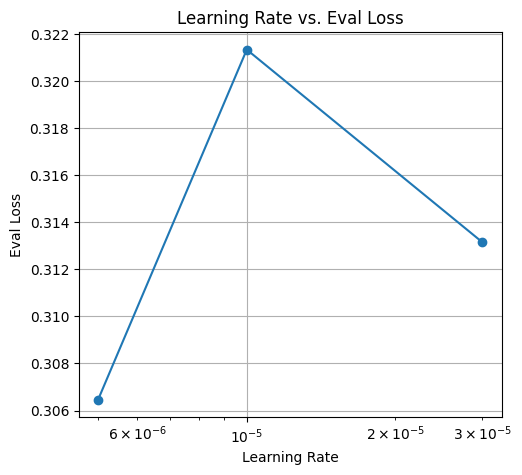

In [ ]:
import matplotlib.pyplot as plt

# Get eval_loss
eval_loss = [results[lr]['eval_loss'] for lr in learning_rates]

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(learning_rates, eval_loss, marker='o')
plt.title('Learning Rate vs. Eval Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Eval Loss')
plt.xscale('log')
plt.grid(True)
plt.show()


According to the result of 'Learning Rate vs. Eval Loss', the optimized learning rate is 5e-6.

#### 3.1.2 Batch Size

In [ ]:
# Load pre-trained BERT model with a classification head
subset_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimize the batch size
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

batch_sizes = [16, 32, 64]
results = {}

for bs in batch_sizes:
  # Load pre-trained BERT model with a classification head
  subset_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

  training_args = TrainingArguments(
        output_dir=f'./results_bs_{bs}',
        num_train_epochs=10,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'./logs_bs_{bs}',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-6,
        run_name=f'video_game_review_bs_{bs}',
        load_best_model_at_end=True
    )

  trainer = Trainer(
      model=subset_model,
      args=training_args,
      train_dataset=train_subset_bert,
      eval_dataset=val_subset_bert,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
  )

  trainer.train()

  eval_results = trainer.evaluate()
  results[bs] = eval_results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.653300,0.665812
2,0.513600,0.483383
3,0.305100,0.339120
4,0.310500,0.323745
5,0.279600,0.330953
6,0.178200,0.354221


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.664300,0.666547
2,0.612100,0.608639
3,0.469000,0.469276
4,0.427800,0.369734
5,0.302800,0.339069
6,0.267400,0.326459
7,0.266100,0.338379
8,0.241800,0.329536


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 327.06 MiB is free. Process 27048 has 14.43 GiB memory in use. Of the allocated memory 14.05 GiB is allocated by PyTorch, and 246.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for bs, result in results.items():
    print(f"Batch size: {bs}")
    print(result)

Batch size: 16
{'eval_loss': 0.3237452805042267, 'eval_runtime': 46.4623, 'eval_samples_per_second': 33.898, 'eval_steps_per_second': 2.131, 'epoch': 6.0}
Batch size: 32
{'eval_loss': 0.3264591097831726, 'eval_runtime': 46.4941, 'eval_samples_per_second': 33.875, 'eval_steps_per_second': 1.075, 'epoch': 8.0}


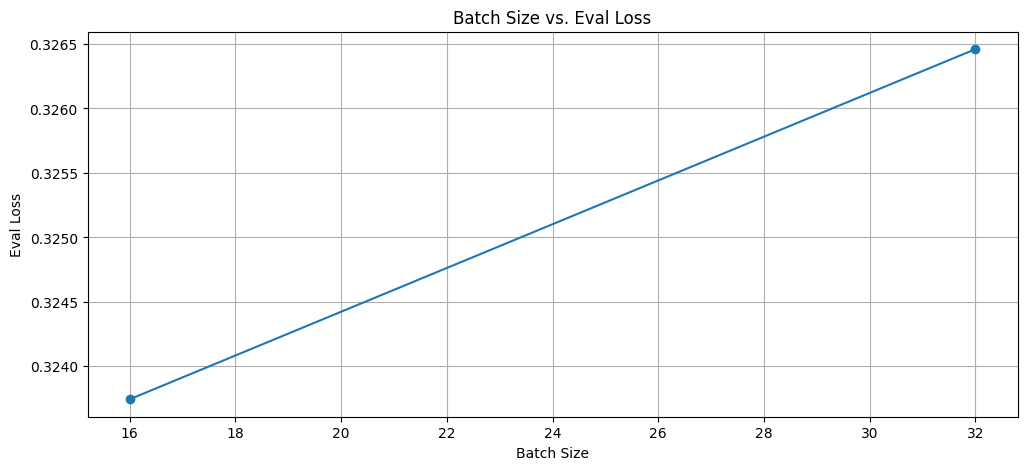

In [ ]:
import matplotlib.pyplot as plt

# Re-modify the batch sizes
batch_sizes = [16, 32]

# Get eval_loss
eval_loss = [results[bs]['eval_loss'] for bs in batch_sizes]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(batch_sizes, eval_loss, marker='o')
plt.title('Batch Size vs. Eval Loss')
plt.xlabel('Batch Size')
plt.ylabel('Eval Loss')
# plt.xscale('log')
plt.grid(True)
plt.show()

Since my GPU run out of memory when it tried to train the model with 64 batch-size, I only train the batch-size of 16 and 32. In contrast of these two, batch-size 16 has a slightly lower eval loss. Hence, the optimized batch-size is 16.

#### 3.1.3 Weight Decay

In [ ]:
# Optimize the weight decay
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

weight_decays = [0.1, 0.01, 0.001]
results = {}

for wd in weight_decays:
  # Load pre-trained BERT model with a classification head
  subset_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

  training_args = TrainingArguments(
        output_dir=f'./results_wd_{wd}',
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=wd,
        logging_dir=f'./logs_wd_{wd}',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-6,
        run_name=f'video_game_review_wd_{wd}',
        load_best_model_at_end=True
    )

  trainer = Trainer(
      model=subset_model,
      args=training_args,
      train_dataset=train_subset_bert,
      eval_dataset=val_subset_bert,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
  )

  trainer.train()

  eval_results = trainer.evaluate()
  results[wd] = eval_results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.631900,0.631930
2,0.497700,0.490467
3,0.323800,0.376485
4,0.290400,0.344341
5,0.280300,0.340913
6,0.195800,0.359535
7,0.174200,0.383728


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.629500,0.640819
2,0.492500,0.464736
3,0.297600,0.330511
4,0.278800,0.320625
5,0.262500,0.332693
6,0.164800,0.350124


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.627800,0.634159
2,0.484800,0.439490
3,0.281500,0.335753
4,0.281900,0.336613
5,0.263900,0.331678
6,0.172500,0.353874
7,0.172000,0.380178


In [ ]:
for wd, result in results.items():
    print(f"Weight Decay: {wd}")
    print(result)

Weight Decay: 0.1
{'eval_loss': 0.3409128487110138, 'eval_runtime': 46.4558, 'eval_samples_per_second': 33.903, 'eval_steps_per_second': 2.131, 'epoch': 7.0}
Weight Decay: 0.01
{'eval_loss': 0.3206247091293335, 'eval_runtime': 46.2967, 'eval_samples_per_second': 34.02, 'eval_steps_per_second': 2.138, 'epoch': 6.0}
Weight Decay: 0.001
{'eval_loss': 0.3316779136657715, 'eval_runtime': 46.6236, 'eval_samples_per_second': 33.781, 'eval_steps_per_second': 2.123, 'epoch': 7.0}


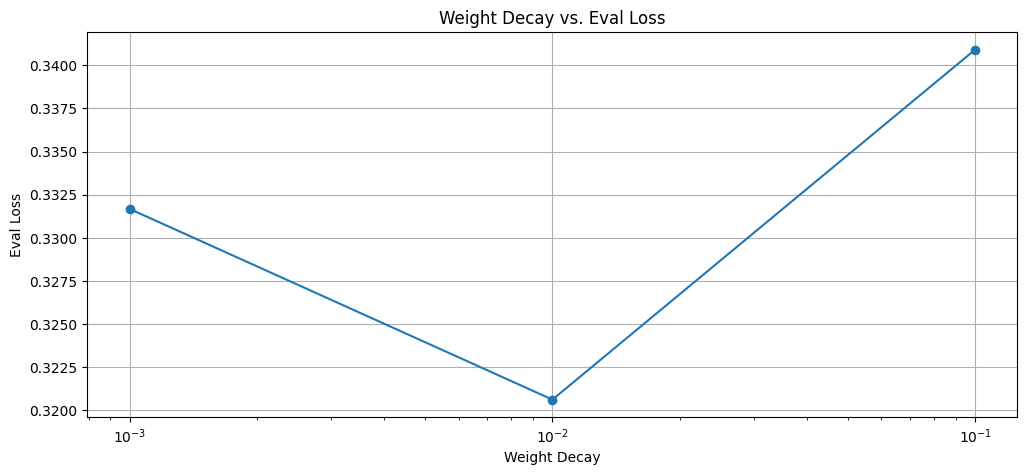

In [ ]:
import matplotlib.pyplot as plt

# Get eval_loss
eval_loss = [results[wd]['eval_loss'] for wd in weight_decays]

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(weight_decays, eval_loss, marker='o')
plt.title('Weight Decay vs. Eval Loss')
plt.xlabel('Weight Decay')
plt.ylabel('Eval Loss')
plt.xscale('log')
plt.grid(True)
plt.show()

According to the plot 'Weight Decay vs. Eval Loss', weight_decay=0.01 is the optimized result.

### 3.2 BERT Model Training on Original Dataset
The original dataset will be splited into train, validation and test datasets. <b>The 'original' is only used to corresponding to the stratified sampling dataset above.</b>

In [8]:
# Original train_test_split for dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset

df_train, df_val = train_test_split(df_with_label, test_size=0.3, stratify=df_with_label['user_suggestion'])
train_dataset_bert = Dataset.from_pandas(df_train)
val_dataset_bert = Dataset.from_pandas(df_val)

In [9]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [10]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['user_review_bert'], padding='max_length', truncation=True)

# Apply the tokenization to both the training and validation datasets
train_dataset_bert = train_dataset_bert.map(tokenize_function, batched=True)
val_dataset_bert = val_dataset_bert.map(tokenize_function, batched=True)

# Ensure 'labels' column is in the datasets
train_dataset_bert = train_dataset_bert.rename_column("user_suggestion", "labels")
val_dataset_bert = val_dataset_bert.rename_column("user_suggestion", "labels")

# Set format for PyTorch
train_dataset_bert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_bert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/12245 [00:00<?, ? examples/s]

Map:   0%|          | 0/5249 [00:00<?, ? examples/s]

In [11]:
# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# The optimized hyperparameters are used in the TrainingArguments
training_args = TrainingArguments(
    output_dir='./results_final',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_final',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    run_name='final_video_game_review_sentiment_analysis',
    load_best_model_at_end=True
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

trainer = Trainer(
    model=model,                         # The pre-trained BERT model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset_bert,         # The training dataset
    eval_dataset=val_dataset_bert,            # The validation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

#### 3.2.1 Model Training

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.307700,0.289362
2,0.279800,0.299496
3,0.217700,0.301558


TrainOutput(global_step=2298, training_loss=0.31996503635735174, metrics={'train_runtime': 3794.8119, 'train_samples_per_second': 16.134, 'train_steps_per_second': 1.009, 'total_flos': 9665384618649600.0, 'train_loss': 0.31996503635735174, 'epoch': 3.0})

#### 3.2.2 Save model output

In [ ]:
output_dir = "/content/drive/My Drive/Video game review sentiment analysis/saved_model_bert/"
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/drive/My Drive/Video game review sentiment analysis/saved_model_bert/


#### 3.2.3 Load model output

In [14]:
from transformers import BertForSequenceClassification, BertTokenizer
output_dir = "/content/drive/My Drive/Video game review sentiment analysis/saved_model_bert/"
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=1)
  labels = p.label_ids

  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1
  }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=compute_metrics
)

### 3.3 Performance Evaluation

#### 3.3.1 Evaluation on Testing Data

In [ ]:
  eval_results = trainer.evaluate()
  print(eval_results)

{'eval_loss': 0.28936195373535156, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.8837873880739189, 'eval_precision': 0.9181594661046716, 'eval_recall': 0.8739551989301237, 'eval_f1': 0.8955121616992121, 'eval_runtime': 152.9364, 'eval_samples_per_second': 34.321, 'eval_steps_per_second': 2.151}


The results of the evaluation are as follow:<br>
Evaluation Loss: 0.2894<br>
Accuracy: 0.8838<br>
Precision: 0.9182<br>
Recall: 0.8740<br>
F1-score: 0.8955<br>
<br>
The trained BERT model has a great performance on the given dataset(validation set).

#### 3.3.2 Evaluation on Unseen Dataset

In [43]:
# Load unseen dataset and remove all the 'Average' beacuse the train model only work for positive and negative
df_unseen = pd.read_csv('/content/drive/My Drive/Video game review sentiment analysis/dataset/unseen_dataset.csv')
df_unseen = df_unseen[df_unseen['rating'] != 'Average']


In [44]:
# Preprocessing for the unseen dataset
df_unseen['review_bert'] = df_unseen['review'].apply(cleaning_text_bert)

In [45]:
# Predict the label of the review (rating)
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_review_bert(review):
  inputs = tokenizer(review, return_tensors='pt', padding=True, truncation=True, max_length=128)
  inputs = {key: value.to(device) for key, value in inputs.items()}

  with torch.no_grad():
    outputs = model(**inputs)

  predicted_label = torch.argmax(outputs.logits, dim=1).item()

  return predicted_label

df_unseen['predicted_label'] = df_unseen['review_bert'].apply(predict_review_bert)

df_unseen.head()

,Unnamed: 0,video game,date,score,review,rating,review_bert,predicted_label
0,0,the-lord-of-the-rings---gollum,27-Jul-23,0,⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀...,Negative,⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀...,0
1,1,the-lord-of-the-rings---gollum,24-Jul-23,0,so horrendously bad I **** my pants and had a ...,Negative,so horrendously bad i **** my pants and had a ...,0
2,2,the-lord-of-the-rings---gollum,22-Jul-23,1,This game is inspirational.\rAfter playing thi...,Negative,this game is inspirational.\rafter playing thi...,1
3,3,the-lord-of-the-rings---gollum,20-Jul-23,0,Typical after-2013 game (huge hype and then hu...,Negative,typical after-2013 game (huge hype and then hu...,0
5,5,the-lord-of-the-rings---gollum,1-Jul-23,0,==========even free or watch it on utube not w...,Negative,==========even free or watch it on utube not w...,0


In [48]:
# Calculate the accuracy and generate report for the unseen dataset testing
from sklearn.metrics import accuracy_score, classification_report

# Mapping the labels of rating
label_mapping = {'Positive': 1, 'Negative': 0}
df_unseen['true_label'] = df_unseen['rating'].map(label_mapping)

# Generate accuracy and report
accuracy = accuracy_score(df_unseen['true_label'], df_unseen['predicted_label'])
report = classification_report(df_unseen['true_label'], df_unseen['predicted_label'], target_names=['negative', 'positive'])

print("Accuracy:", accuracy)
print("\n")
print("Classification Report:\n", report)


Accuracy: 0.8472816127061699


Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.80      0.86      2762
    positive       0.78      0.90      0.84      2149

    accuracy                           0.85      4911
   macro avg       0.85      0.85      0.85      4911
weighted avg       0.86      0.85      0.85      4911



## 4. Keywords Extraction

### 4.1 Predict New Dataset

In [ ]:
# Load new dataset
df_without_label = pd.read_csv('/content/drive/My Drive/Video game review sentiment analysis/dataset/steam game review dataset/test_gr/test.csv')
df_without_label.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [ ]:
df_without_label['user_review_bert'] = df_without_label['user_review'].apply(cleaning_text_bert)
df_without_label.head()

,review_id,title,year,user_review,user_review_bert
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B...","nice graphics, new maps, weapons and models. b..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...,i would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...,edit 11/12/18i have tried playing cs:go recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...,the game is great. but the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...,i thank trulyrazor for buying this for me a lo...


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import pandas as pd

def predict_review_bert(review):
  inputs = tokenizer(review, return_tensors='pt', padding=True, truncation=True, max_length=128)

  with torch.no_grad():
    outputs = model(**inputs)

  predicted_label = torch.argmax(outputs.logits, dim=1).item()

  return predicted_label

df_without_label['predicted_label'] = df_without_label['user_review'].apply(predict_review_bert)

df_without_label.head()

,review_id,title,year,user_review,user_review_bert,predicted_label
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B...","nice graphics, new maps, weapons and models. b...",0
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...,i would not recommend getting into this at its...,0
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...,edit 11/12/18i have tried playing cs:go recent...,0
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...,the game is great. but the community is the wo...,0
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...,i thank trulyrazor for buying this for me a lo...,0


In [ ]:
# Classify positive and negative reviews
positive_reviews_1 = df_without_label[df_without_label['predicted_label'] == 1]
negative_reviews_1 = df_without_label[df_without_label['predicted_label'] == 0]

print(f"Number of positive reviews: {len(positive_reviews_1)}")
print(f"Number of negative reviews: {len(negative_reviews_1)}")

Number of positive reviews: 4304
Number of negative reviews: 3741


### 4.2 Latent Dirichlet Allocation (LDA) - Extract Key Content from Review

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def tokenize_lda(review):
  tokens = word_tokenize(review)
  tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
  return tokens

positive_reviews_1 = positive_reviews_1['user_review_bert'].apply(tokenize_lda).tolist()
negative_reviews_1 = negative_reviews_1['user_review_bert'].apply(tokenize_lda).tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### 4.2.1 N-gram to get 2-word or 3-word phrases

In [ ]:
# N-gram
from gensim.models import Phrases

positive_tokens_1 = [review for review in positive_reviews_1]
negative_tokens_1 = [review for review in negative_reviews_1]

# Create bi-gram and tri-gram model
bigram = Phrases(positive_tokens_1 + negative_tokens_1, min_count=2, threshold=100)
trigram = Phrases(bigram[positive_tokens_1 + negative_tokens_1], threshold=50)

positive_reviews_ngrams_1 = [trigram[bigram[review]] for review in positive_tokens_1]
negative_reviews_ngrams_1 = [trigram[bigram[review]] for review in negative_tokens_1]

#### 4.2.2 TF-IDF

In [ ]:
# TF-IDF to remove low-frequent phrases
from sklearn.feature_extraction.text import TfidfVectorizer

positive_reviews_text_1 = [" ".join(review) for review in positive_reviews_ngrams_1]
negative_reviews_text_1 = [" ".join(review) for review in negative_reviews_ngrams_1]

tfidf_vectorizer_1 = TfidfVectorizer(max_df=0.8, min_df=3, max_features=1000, stop_words='english')

positive_tfidf_1 = tfidf_vectorizer_1.fit_transform(positive_reviews_text_1)
negative_tfidf_1 = tfidf_vectorizer_1.transform(negative_reviews_text_1)

positive_filtered_words_1 = tfidf_vectorizer_1.get_feature_names_out()
negative_filtered_words_1 = tfidf_vectorizer_1.get_feature_names_out()

positive_reviews_filtered_1 = [[word for word in review.split() if word in positive_filtered_words_1] for review in positive_reviews_text_1]
negative_reviews_filtered_1 = [[word for word in review.split() if word in negative_filtered_words_1] for review in negative_reviews_text_1]

#### 4.2.3 Filter Extremes

In [ ]:
# Create bag and dictionary by filter_extremes
from gensim import corpora

positive_reviews_filtered_1 = [[word for word in review if len(word.split('_')) in [2, 3]] for review in positive_reviews_filtered_1]
negative_reviews_filtered_1 = [[word for word in review if len(word.split('_')) in [2, 3]] for review in negative_reviews_filtered_1]

positive_dictionary = corpora.Dictionary(positive_reviews_filtered_1)
positive_dictionary.filter_extremes(no_below=2, no_above=0.8)
positive_corpus = [positive_dictionary.doc2bow(review) for review in positive_reviews_filtered_1]

negative_dictionary = corpora.Dictionary(negative_reviews_filtered_1)
negative_dictionary.filter_extremes(no_below=2, no_above=0.8)
negative_corpus = [negative_dictionary.doc2bow(review) for review in negative_reviews_filtered_1]

#### 4.2.4 LDA

In [ ]:
# Train LDA model
from gensim.models import LdaModel

num_topics = 5

positive_lda_1 = LdaModel(positive_corpus, num_topics=num_topics, id2word=positive_dictionary, passes=20)
negative_lda_1 = LdaModel(negative_corpus, num_topics=num_topics, id2word=negative_dictionary, passes=20)

In [ ]:
print("Positive Review Topics and Keywords:")
for idx, topic in positive_lda_1.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

print("\nNegative Review Topics and Keywords:")
for idx, topic in negative_lda_1.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Positive Review Topics and Keywords:
Topic 1: 0.538*"pay_win" + 0.126*"early_access_reviewthe" + 0.090*"clash_royale" + 0.080*"come_back" + 0.079*"negative_reviews" + 0.071*"turbine_points" + 0.000*"real_money" + 0.000*"lord_rings" + 0.000*"tower_defense" + 0.000*"fishing_simulator"
Topic 2: 0.287*"aura_kingdom" + 0.204*"early_access_reviewthis" + 0.190*"gon_na" + 0.061*"champions_online" + 0.058*"character_customization" + 0.052*"dungeon_defenders" + 0.051*"lord_rings" + 0.043*"ragnarok_online" + 0.023*"fishing_simulator" + 0.022*"art_style"
Topic 3: 0.252*"early_access_reviewi" + 0.173*"magic_gathering" + 0.144*"magic_duels" + 0.100*"story_mode" + 0.070*"daily_quests" + 0.055*"deck_building" + 0.053*"cash_shop" + 0.051*"global_offensive" + 0.050*"fishing_planet" + 0.043*"single_player"
Topic 4: 0.271*"star_trek" + 0.172*"real_life" + 0.151*"highly_recommend" + 0.080*"character_creation" + 0.079*"star_trek_online" + 0.071*"middle_earth" + 0.058*"star_trek_fan" + 0.049*"space_combat" +

#### 4.2.5 Visualization from LDA - Gain Insights from Key Phrases

In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 87.6 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_vis_data = gensimvis.prepare(positive_lda_1, positive_corpus, positive_dictionary)
pyLDAvis.display(lda_vis_data)


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_vis_data = gensimvis.prepare(negative_lda_1, negative_corpus, negative_dictionary)
pyLDAvis.display(lda_vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.3 Prediction of steam review of Elden Ring

In [ ]:
# Load dataset of Steam review
df_er = pd.read_csv('/content/drive/My Drive/Video game review sentiment analysis/dataset/elden_ring_steam_reviews.csv')
df_er = df_er[['review']]
df_er.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review
0,being killed over and over again is fun
1,I write this review as I have 100% completed E...
2,Fun
3,pretty cool.
4,AMAZINGGGGGGGGGGGGG


In [ ]:
# Preprocessing for Elden Ring review

# Make sure all the value is converted to string
# df_er['review'] = df_er['review'].astype(str)

# Remove all the NaN reviews
df_er = df_er.dropna(subset=['review'])

df_er['review'] = df_er['review'].apply(cleaning_text_bert)
df_er.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-74-14e8b0890432>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_er['review'] = df_er['review'].apply(cleaning_text_bert)


,review
0,being killed over and over again is fun
1,i write this review as i have 100% completed e...
2,fun
3,pretty cool.
4,amazinggggggggggggg


#### 4.3.1 Prediction of Dataset about Elden Ring

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import pandas as pd

def predict_review_bert(review):
  inputs = tokenizer(review, return_tensors='pt', padding=True, truncation=True, max_length=128)

  with torch.no_grad():
    outputs = model(**inputs)

  predicted_label = torch.argmax(outputs.logits, dim=1).item()

  return predicted_label

df_er['predicted_label'] = df_er['review'].apply(predict_review_bert)

df_er.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review,predicted_label
0,being killed over and over again is fun,1
1,i write this review as i have 100% completed e...,1
2,fun,1
3,pretty cool.,1
4,amazinggggggggggggg,0


In [ ]:
# Classify positive and negative reviews
positive_reviews_2 = df_er[df_er['predicted_label'] == 1]
negative_reviews_2 = df_er[df_er['predicted_label'] == 0]

print(f"Number of positive reviews: {len(positive_reviews_2)}")
print(f"Number of negative reviews: {len(negative_reviews_2)}")

Number of positive reviews: 6216
Number of negative reviews: 3549


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 4.3.2 Extract Key phrases from dataset

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def tokenize_lda(review):
  tokens = word_tokenize(review)
  tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
  return tokens

positive_reviews_2 = positive_reviews_2['review'].apply(tokenize_lda).tolist()
negative_reviews_2 = negative_reviews_2['review'].apply(tokenize_lda).tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# N-gram
from gensim.models import Phrases

positive_tokens_2 = [review for review in positive_reviews_2]
negative_tokens_2 = [review for review in negative_reviews_2]

# Bi-gram 和 tri-gram for positive reviews
positive_bigram = Phrases(positive_tokens_2, min_count=2, threshold=100)
positive_trigram = Phrases(positive_bigram[positive_tokens_2], threshold=50)
positive_reviews_ngrams_2 = [positive_trigram[positive_bigram[review]] for review in positive_tokens_2]

# Bi-gram 和 tri-gram for negative reviews
negative_bigram = Phrases(negative_tokens_2, min_count=2, threshold=100)
negative_trigram = Phrases(negative_bigram[negative_tokens_2], threshold=50)
negative_reviews_ngrams_2 = [negative_trigram[negative_bigram[review]] for review in negative_tokens_2]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# TF-IDF to remove low-frequent phrases
from sklearn.feature_extraction.text import TfidfVectorizer

positive_reviews_text_2 = [" ".join(review) for review in positive_reviews_ngrams_2]
negative_reviews_text_2 = [" ".join(review) for review in negative_reviews_ngrams_2]

positive_tfidf_vectorizer_2 = TfidfVectorizer(max_df=0.8, min_df=3, max_features=1000, stop_words='english')
negative_tfidf_vectorizer_2 = TfidfVectorizer(max_df=0.8, min_df=3, max_features=1000, stop_words='english')

positive_tfidf_2 = positive_tfidf_vectorizer_2.fit_transform(positive_reviews_text_2)
negative_tfidf_2 = negative_tfidf_vectorizer_2.fit_transform(negative_reviews_text_2)

positive_filtered_words_2 = positive_tfidf_vectorizer_2.get_feature_names_out()
negative_filtered_words_2 = negative_tfidf_vectorizer_2.get_feature_names_out()

positive_reviews_filtered_2 = [[word for word in review.split() if word in positive_filtered_words_2] for review in positive_reviews_text_2]
negative_reviews_filtered_2 = [[word for word in review.split() if word in negative_filtered_words_2] for review in negative_reviews_text_2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define meaningless phrases, manually ban some phrases haven't filtered
meaningless_phrases = {"wan_na", "gon_na", "elden_ring", "ever_played", "right_right"}

positive_reviews_filtered_2 = [[word for word in review if word not in meaningless_phrases] for review in positive_reviews_filtered_2]
negative_reviews_filtered_2 = [[word for word in review if word not in meaningless_phrases] for review in negative_reviews_filtered_2]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create bag and dictionary by filter_extremes
from gensim import corpora

positive_reviews_filtered_2 = [[word for word in review if len(word.split('_')) in [2, 3]] for review in positive_reviews_filtered_2]
negative_reviews_filtered_2 = [[word for word in review if len(word.split('_')) in [2, 3]] for review in negative_reviews_filtered_2]

positive_dictionary = corpora.Dictionary(positive_reviews_filtered_2)
positive_dictionary.filter_extremes(no_below=2, no_above=0.8)
positive_corpus = [positive_dictionary.doc2bow(review) for review in positive_reviews_filtered_2]

negative_dictionary = corpora.Dictionary(negative_reviews_filtered_2)
negative_dictionary.filter_extremes(no_below=2, no_above=0.8)
negative_corpus = [negative_dictionary.doc2bow(review) for review in negative_reviews_filtered_2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Train LDA model
from gensim.models import LdaModel

num_topics = 5

positive_lda_2 = LdaModel(positive_corpus, num_topics=num_topics, id2word=positive_dictionary, passes=20)
negative_lda_2 = LdaModel(negative_corpus, num_topics=num_topics, id2word=negative_dictionary, passes=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Positive Review Topics and Keywords:")
for idx, topic in positive_lda_2.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

print("\nNegative Review Topics and Keywords:")
for idx, topic in negative_lda_2.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")

Positive Review Topics and Keywords:
Topic 1: 0.290*"highly_recommend" + 0.186*"demon_souls" + 0.143*"replay_value" + 0.081*"build_variety" + 0.079*"tree_sentinel" + 0.052*"hold_hand" + 0.045*"absolute_masterpiece" + 0.044*"coming_back" + 0.040*"multiple_times" + 0.001*"fire_giant"
Topic 2: 0.670*"dark_souls" + 0.089*"elden_lord" + 0.064*"ive_ever" + 0.054*"worth_money" + 0.036*"praise_sun" + 0.023*"breath_wild" + 0.022*"godskin_duo" + 0.020*"action_rpg" + 0.000*"fire_giant" + 0.000*"different_builds"
Topic 3: 0.173*"combat_system" + 0.172*"come_back" + 0.132*"weapons_spells" + 0.093*"previous_titles" + 0.086*"malenia_blade_miquella" + 0.083*"full_price" + 0.080*"learning_curve" + 0.074*"ca_wait_dlc" + 0.071*"rage_quit" + 0.001*"open_world"
Topic 4: 0.298*"open_world" + 0.219*"boss_fights" + 0.091*"ashes_war" + 0.074*"git_gud" + 0.060*"steam_deck" + 0.049*"single_player" + 0.045*"every_corner" + 0.034*"art_direction" + 0.034*"wish_could" + 0.033*"goty_reason"
Topic 5: 0.441*"open_world

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 4.3.3 Key Phrases from Positive Reviews

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_vis_data = gensimvis.prepare(positive_lda_2, positive_corpus, positive_dictionary)
pyLDAvis.display(lda_vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 4.3.4 Key Phrases from Negative Reviews

In [ ]:
lda_vis_data = gensimvis.prepare(negative_lda_2, negative_corpus, negative_dictionary)
pyLDAvis.display(lda_vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
